In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, make_scorer
from sklearn.model_selection import KFold
import lightgbm as lgb

# from sklearn.feature_selection import SelectKBest, f_regression

Matplotlib is building the font cache using fc-list. This may take a moment.


In [2]:
np.random.seed(7)

# metrics

In [45]:
def mae(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    over_threshold = y_true >= 0.1
    
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    remove_NAs = y_true >= 0
    
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    
    return (f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    return 1
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def score(y_val, pred):
    f_value =  fscore(y_val, pred)
    mae_value = maeOverFscore(y_val, pred)
    print(f"fscore        : {f_value}")
    print(f"maeOverFscore : {mae_value}")
    
    return (f_value, mae_value)

def maeOverFscore_lgb(y_true, y_pred):
    return ("maeOverFscore", mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07), False)

def fscore_lgb(y_true, y_pred):
    return ("fscore", fscore(y_true, y_pred), False)

fscore_sklearn = make_scorer(fscore)
maeOverFscore_sklearn = make_scorer(maeOverFscore)


# data load

In [46]:
base = os.getcwd()
data_path = os.path.join(base, 'data')
submit_path = os.path.join(base, 'submit')
model_path = os.path.join(base, 'model')

def load_data(name):
    return np.load(os.path.join(data_path, f"{name}.npy"))

def reshape(data):
    return data.reshape(data.shape[0] * 40 * 40, data.shape[-1])

In [5]:
data = reshape(load_data('dl_train'))

# seperate dataset

In [6]:
X = data[:, :-1]
Y = data[:,  -1].reshape(data.shape[0], 1)
data = range(data.shape[0])
print(X.shape, Y.shape)

(121561600, 14) (121561600, 1)


In [51]:
help(lgb.LGBMRegressor)

Help on class LGBMRegressor in module lightgbm.sklearn:

class LGBMRegressor(LGBMModel, sklearn.base.RegressorMixin)
 |  LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=-1, silent=True, importance_type='split', **kwargs)
 |  
 |  LightGBM regressor.
 |  
 |  Method resolution order:
 |      LGBMRegressor
 |      LGBMModel
 |      sklearn.base.BaseEstimator
 |      sklearn.base.RegressorMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  fit(self, X, y, sample_weight=None, init_score=None, eval_set=None, eval_names=None, eval_sample_weight=None, eval_init_score=None, eval_metric=None, early_stopping_rounds=None, verbose=True, feature_name='auto', categorical_feature='auto', callbac

In [47]:
clf = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.01, \
                        n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, \
                        min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, \
                        subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, \
                        random_state=7, n_jobs=- 1, silent=True, importance_type='split')

In [49]:
clf.fit(X[:1000000, :], Y[:1000000, 0], eval_set=[(X[-1000000:, :], Y[-1000000:, 0])], \
        eval_metric=[maeOverFscore_sklearn, fscore_sklearn], eval_names =["maeOverFscore", "fscore"],\
        early_stopping_rounds=50, \
        verbose=True)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:253: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  warnings.warn("Usage of np.ndarray subset (sliced data) is not recommended "


[1]	maeOverFscore's l2: 2.48526
Training until validation scores don't improve for 50 rounds
[2]	maeOverFscore's l2: 2.47236
[3]	maeOverFscore's l2: 2.46006
[4]	maeOverFscore's l2: 2.44751
[5]	maeOverFscore's l2: 2.43565
[6]	maeOverFscore's l2: 2.42431
[7]	maeOverFscore's l2: 2.41347
[8]	maeOverFscore's l2: 2.40251
[9]	maeOverFscore's l2: 2.39159
[10]	maeOverFscore's l2: 2.3818
[11]	maeOverFscore's l2: 2.37148
[12]	maeOverFscore's l2: 2.36184
[13]	maeOverFscore's l2: 2.35224
[14]	maeOverFscore's l2: 2.34296
[15]	maeOverFscore's l2: 2.33398
[16]	maeOverFscore's l2: 2.32542
[17]	maeOverFscore's l2: 2.31694
[18]	maeOverFscore's l2: 2.30903
[19]	maeOverFscore's l2: 2.30178
[20]	maeOverFscore's l2: 2.2943
[21]	maeOverFscore's l2: 2.28696
[22]	maeOverFscore's l2: 2.2804
[23]	maeOverFscore's l2: 2.2738
[24]	maeOverFscore's l2: 2.26215
[25]	maeOverFscore's l2: 2.25607
[26]	maeOverFscore's l2: 2.24519
[27]	maeOverFscore's l2: 2.23674
[28]	maeOverFscore's l2: 2.23116
[29]	maeOverFscore's l2: 2.2

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=7, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
params = {
    boosting_type:'gbdt', num_leaves:31, max_depth:- 1, learning_rate:0.01, \
                        n_estimators:10, subsample_for_bin:200000, objective=None, class_weight=None, \
                        min_split_gain:0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, \
                        subsample_freq:0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, \
                        random_state=7, n_jobs=- 1, silent=True, importance_type='split'
    
}

In [26]:
clf_train = lgb.train(params, train_set, num_boost_round=1000, valid_sets=None, valid_names="val", \
               fobj=None, feval=None, init_model=None, feature_name='auto', categorical_feature='auto', \
               early_stopping_rounds=50, evals_result=None, verbose_eval=10, learning_rates=None, \
               keep_training_booster=False, callbacks=None)

NameError: name 'params' is not defined

In [ ]:
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 3, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.01,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'}

In [29]:
params = {'learning_rate': 0.01, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mae', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':2018}

In [32]:
clf = lgb.train(params, train, num_boost_round=100, valid_sets=val, valid_names="val", \
           fobj=None, feval=[maeOverFscore_lgb], init_model=None, feature_name='auto', categorical_feature='auto', \
           early_stopping_rounds=50, evals_result=results, verbose_eval=10, learning_rates=0.01, \
           keep_training_booster=False, callbacks=None)

best_iterations.append(clf.best_iteration_)
best_scores.append(clf.best_score_.values())

TypeError: 'float' object is not callable

In [30]:
kfold = KFold(n_splits=4, random_state=7, shuffle=False)
scores = list()
best_iterations = list()
best_scores = list()
results = dict()

for i, (train_idx, val_idx) in enumerate(kfold.split(data)):
    train = lgb.Dataset(X[train_idx, :],  Y[train_idx, 0])
    val = lgb.Dataset(X[val_idx, :],  Y[val_idx, 0])

    
    clf = lgb.train(params, train, num_boost_round=100, valid_sets=val, valid_names="val", \
               fobj=None, feval=[maeOverFscore_lgb. fscore_lgb], init_model=None, feature_name='auto', categorical_feature='auto', \
               early_stopping_rounds=50, evals_result=results, verbose_eval=10, learning_rates=0.01, \
               keep_training_booster=False, callbacks=None)
    
    best_iterations.append(clf.best_iteration_)
    best_scores.append(clf.best_score_.values())
#     clf.booster_.save_model('clf.txt')
    
    scores.append(score(clf.predict(X[val_idx, :]), Y[val_idx, :]))

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


NameError: name 'lightgbm' is not defined

In [27]:
train = lgb.Dataset(X, Y)




In [28]:
train

# K-Fold

In [ ]:
kfold = KFold(n_splits=4, random_state=7, shuffle=False)
scores = list()
best_iterations = list()
best_scores = list()


for i, (train_idx, val_idx) in enumerate(kfold.split(data)):
    clf = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.01, \
                            n_estimators=10000, subsample_for_bin=200000, objective=None, class_weight=None, \
                            min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, \
                            subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, \
                            random_state=7, n_jobs=- 1, silent=True, importance_type='split')
    

    clf.fit(X[train_idx, :], Y[train_idx, 0], eval_set=[(X[val_idx, :], Y[val_idx, 0])], \
            eval_metric=["MAE", "MSE"], \
            early_stopping_rounds=50, \
            verbose=True)
    
    best_iterations.append(clf.best_iteration_)
    best_scores.append(clf.best_score_.values())
#     clf.booster_.save_model('clf.txt')
    
    scores.append(score(clf.predict(X[val_idx, :]), Y[val_idx, :]))

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
lgb.plot_importance(clf, ax)

# LGBMRegressor

In [6]:
clf = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.01, \
                        n_estimators=800, subsample_for_bin=200000, objective=None, class_weight=None, \
                        min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, \
                        subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, \
                        random_state=7, n_jobs=- 1, silent=True, importance_type='split')

In [7]:
clf.fit(X, Y, verbose=True)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=800, n_jobs=-1, num_leaves=31, objective=None,
              random_state=7, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

# 시각화

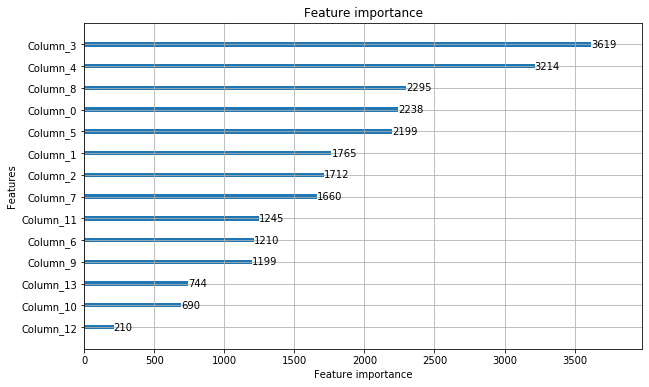

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
lgb.plot_importance(clf, ax)

# 제출

In [9]:
def submit(clf, name, preprocess=None):
    x_test = reshape(load_data('test'))
    
    pred = clf.predict(x_test)

    submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))
    submission.iloc[:, 1:] = pred.reshape(-1, 1600)

    submission.to_csv(os.path.join(submit_path, f'{name}.csv'), index=False)

In [10]:
submit(clf, 'lightbgm_all_31_800')

- https://dacon.io/competitions/official/235591/mysubmission/
- D:\인공지능_공모전\github\submit